In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [6]:
# Step 1: Imports and Data Download (Clean version with 'Close')
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical daily data
tickers = ['SPY', 'TLT', 'GLD', 'BTC-USD']
start_date = '2018-01-01'
end_date = '2024-06-01'

# Download close prices
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Resample to weekly prices (Friday close)
weekly_prices = data.resample('W-FRI').last()

# Preview
weekly_prices.tail()


/tmp/ipykernel_126/2056647223.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed


Ticker,BTC-USD,GLD,SPY,TLT
Date,,,,
2024-05-03,62889.835938,212.960007,503.376221,85.586029
2024-05-10,60792.777344,218.710007,512.778442,85.852791
2024-05-17,67051.875000,223.660004,521.255127,87.062645
2024-05-24,68526.101562,215.919998,521.245300,87.053101
2024-05-31,67491.414062,215.300003,519.207397,86.167160


In [7]:
# Step 2: Calculate Weekly Returns
returns = weekly_prices.pct_change().dropna()

# Step 3: Rolling Mean and Std for 12-week Sharpe Ratio
rolling_mean = returns.rolling(window=12).mean()
rolling_std = returns.rolling(window=12).std()
rolling_sharpe = rolling_mean / rolling_std

# Preview a sample
rolling_sharpe.tail()


Ticker,BTC-USD,GLD,SPY,TLT
Date,,,,
2024-05-03,0.314277,0.490315,0.127258,-0.153566
2024-05-10,0.186184,0.625682,0.233520,-0.083719
2024-05-17,0.305117,0.661010,0.232852,-0.072741
2024-05-24,0.156549,0.376340,0.184181,-0.121404
2024-05-31,0.005810,0.243831,0.174970,-0.244922


In [9]:
# Step 4: Calculate weekly strategy weights (Sharpe-maximising logic)

def compute_weights(sharpes):
    # Set negatives to zero (no exposure)
    sharpes = sharpes.clip(lower=0)
    
    # If all Sharpes are zero or NaN, return equal weights
    if sharpes.sum() == 0 or sharpes.isnull().all():
        return pd.Series([1/len(sharpes)]*len(sharpes), index=sharpes.index)
    
    # Normalise positive Sharpes to sum to 1
    return sharpes / sharpes.sum()

# Apply weekly across all rolling Sharpe values
weights = rolling_sharpe.apply(compute_weights, axis=1)

# Drop first few rows with NaNs
weights = weights.dropna()

# Preview
weights.tail()


Ticker,BTC-USD,GLD,SPY,TLT
Date,,,,
2024-05-03,0.337261,0.526174,0.136565,0.0
2024-05-10,0.178101,0.598518,0.223381,0.0
2024-05-17,0.254481,0.551311,0.194209,0.0
2024-05-24,0.218318,0.524830,0.256852,0.0
2024-05-31,0.013682,0.574246,0.412071,0.0


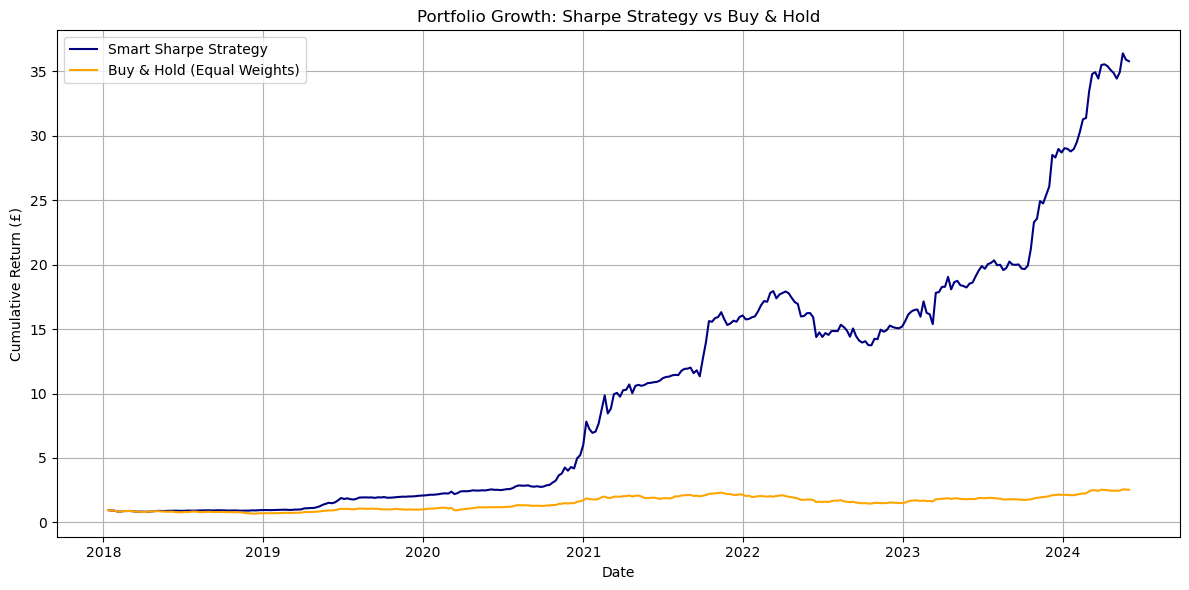

In [12]:
# Step 4A: Align returns to weights (matching weekly dates)
strategy_returns = (weights * returns.loc[weights.index]).sum(axis=1)

# Step 4B: Buy-and-hold = equal weights (25%) throughout
equal_weights = pd.DataFrame(
    np.repeat([[0.25, 0.25, 0.25, 0.25]], len(strategy_returns), axis=0),
    index=strategy_returns.index,
    columns=weights.columns
)
buy_hold_returns = (equal_weights * returns.loc[weights.index]).sum(axis=1)

# Step 4C: Compute cumulative performance
cum_strategy = (1 + strategy_returns).cumprod()
cum_buy_hold = (1 + buy_hold_returns).cumprod()

# Step 4D: Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cum_strategy, label='Smart Sharpe Strategy', color='navy')
plt.plot(cum_buy_hold, label='Buy & Hold (Equal Weights)', color='orange')
plt.title("Portfolio Growth: Sharpe Strategy vs Buy & Hold")
plt.ylabel("Cumulative Return (£)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("chart.png", dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Step 5: Calculate Performance Metrics
def calculate_metrics(cumulative_returns, returns):
    # CAGR
    total_return = cumulative_returns[-1]
    num_years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    cagr = (total_return) ** (1 / num_years) - 1

    # Max Drawdown
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    # Sharpe Ratio (risk-free rate = 0)
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(52)

    return cagr, max_drawdown, sharpe_ratio

# Compute raw returns for Sharpe strategy and Buy & Hold
raw_returns_strategy = strategy_returns
raw_returns_bh = buy_hold_returns

# Compute cumulative returns
cumulative_strategy = (1 + raw_returns_strategy).cumprod()
cumulative_bh = (1 + raw_returns_bh).cumprod()

# Calculate metrics
strategy_cagr, strategy_dd, strategy_sharpe = calculate_metrics(cumulative_strategy, raw_returns_strategy)
bh_cagr, bh_dd, bh_sharpe = calculate_metrics(cumulative_bh, raw_returns_bh)

# Display
print("📈 Smart Sharpe Strategy")
print(f"CAGR:         {strategy_cagr:.2%}")
print(f"Max Drawdown: {strategy_dd:.2%}")
print(f"Sharpe Ratio: {strategy_sharpe:.2f}")

print("\n📊 Buy & Hold (Equal Weights)")
print(f"CAGR:         {bh_cagr:.2%}")
print(f"Max Drawdown: {bh_dd:.2%}")
print(f"Sharpe Ratio: {bh_sharpe:.2f}")


📈 Smart Sharpe Strategy
CAGR:         75.17%
Max Drawdown: -23.41%
Sharpe Ratio: 2.06

📊 Buy & Hold (Equal Weights)
CAGR:         15.66%
Max Drawdown: -36.72%
Sharpe Ratio: 0.81


/tmp/ipykernel_126/1902363930.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = cumulative_returns[-1]
